<a href="https://colab.research.google.com/github/aimbsg/EVA4_S11/blob/master/EVA4_S11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

S11 Model

PrepLayer - Conv 3x3 s1, p1) >> BN >> RELU [64k]

Layer1 -

X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [128k]

R1 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [128k] 

Add(X, R1)

Layer 2 -

Conv 3x3 [256k]

MaxPooling2D

BN

ReLU

Layer 3 -

X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [512k]

R2 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [512k]

Add(X, R2)

MaxPooling with Kernel Size 4

FC Layer 

SoftMax

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
!pip install -U git+https://github.com/albu/albumentations

In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
%cd '/content/gdrive/My Drive/EVA4_S11_CIFAR10_OCP/'

/content/gdrive/My Drive/EVA4_S11_CIFAR10_OCP


In [0]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import data_loader as train_test_loader
import visualize_images as show_images
import backbone as model
import train_test
import model_evaluator as evaluate
from transforms_albumentation import AlbumentationTransforms
from gradcam import GradCAM,visualize_cam

In [0]:
import albumentations as A

channel_means = (0.5, 0.5, 0.5)
channel_stdevs = (0.5, 0.5, 0.5)
train_transform = AlbumentationTransforms([
                                       A.PadIfNeeded(min_height=36, min_width=36, always_apply=True),
                                       A.RandomCrop(32,32),
                                       A.HorizontalFlip(),
                                       A.Normalize(mean=channel_means, std=channel_stdevs),
                                       A.Cutout(num_holes=1, max_h_size=8,max_w_size = 8,p=1),
                                       ])
# Test Phase transformations
test_transform = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs),])

In [5]:
classes, trainloader, testloader = train_test_loader.load(train_transform,test_transform)

Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


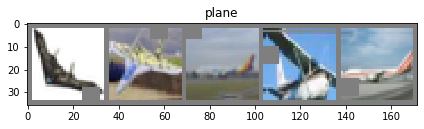

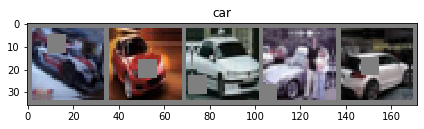

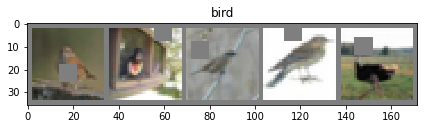

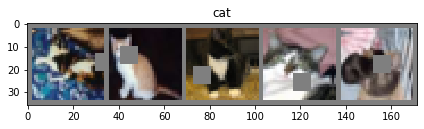

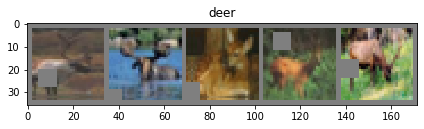

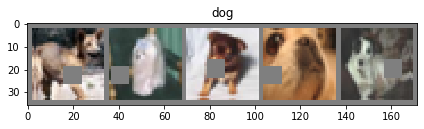

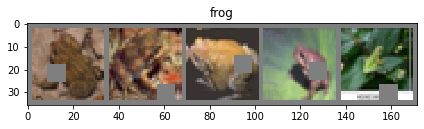

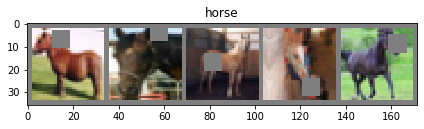

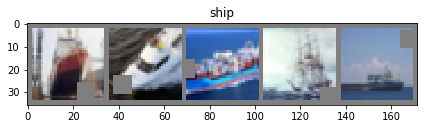

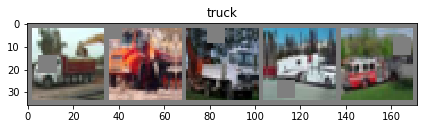

In [0]:
show_images.show_train_data(trainloader, classes)

In [8]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = model.Custom_ResNet().to(device)
summary(model, input_size=(3,32,32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

In [0]:
#@title LR finder package installer
!pip install torch-lr-finder -v --global-option="amp"

In [0]:
import torch_lr_finder as lr
import torch.nn as nn
import torch.optim as optim

lr_criterion = nn.CrossEntropyLoss()
lr_optimiser = optim.SGD(model.parameters(), lr=1e-05,momentum=0.9 ,weight_decay = 0.0001)
lr_finder = lr.LRFinder(model, lr_optimiser, lr_criterion, device="cuda")
lr_finder.range_test(trainloader, val_loader=testloader, end_lr=1, num_iter=500 ,step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


In [0]:
lr_finder.plot()

In [0]:
ideal_lr = lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.best_loss)]
ideal_lr

In [0]:
lr_finder.reset()

In [0]:
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

# criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 0.0005)
# scheduler = OneCycleLR(optimizer = optimizer, max_lr = 0.01, total_steps = 48, epochs = 5, steps_per_epoch = 1, pct_start = 0.2, anneal_strategy = 'linear', cycle_momentum=False, div_factor = 10, final_div_factor = 1)
scheduler = OneCycleLR(optimizer = optimizer, epochs = 24, steps_per_epoch = 2, max_lr = 0.01, div_factor = 10)

In [17]:
train_loss = [] 
train_acc = []
test_loss = []
test_acc = []
epochs = 24
best_acc = 89 # save the model only if the accuracy crosses 89% as we already achieved 88% in previous assignment with LR finder. This is with One Cycle LR

for epoch in range(epochs):
     print("Epoch:", epoch+1,'LR:',optimizer.param_groups[0]['lr'])
     train_test.train(model, device, trainloader, optimizer, criterion, epoch)     
    #  scheduler.step()
     test_loss , test_acc = train_test.test(model, device, criterion, testloader)
     train_loss , train_acc = train_test.train_metrics_accumulator(model, device, criterion, trainloader)
     scheduler.step(test_loss[-1])
    
     if(test_acc[-1]>best_acc):
       print("...BEST MODEL...")
       best_acc = test_acc[-1]
       torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': test_loss[-1],
            }, "/content/gdrive/My Drive/EVA4_S11_CIFAR10_OCP/bestmodel_using_OCP.pt")
       print("Save success...")

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 1 LR: 0.001000000110493282


Loss=0.22548583149909973 Batch_id=97 Accuracy=93.28: 100%|██████████| 98/98 [00:21<00:00,  4.52it/s]



Test set: Average loss: 0.0009, Accuracy: 8556/10000 (85.56%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 2 LR: 0.0010000000995927204


Loss=0.16177387535572052 Batch_id=97 Accuracy=93.60: 100%|██████████| 98/98 [00:21<00:00,  4.46it/s]



Test set: Average loss: 0.0009, Accuracy: 8544/10000 (85.44%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 3 LR: 0.0010000000978617717


Loss=0.18055541813373566 Batch_id=97 Accuracy=94.06: 100%|██████████| 98/98 [00:21<00:00,  4.48it/s]



Test set: Average loss: 0.0009, Accuracy: 8599/10000 (85.99%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 4 LR: 0.0010000000969111519


Loss=0.21867002546787262 Batch_id=97 Accuracy=94.47: 100%|██████████| 98/98 [00:22<00:00,  4.41it/s]



Test set: Average loss: 0.0009, Accuracy: 8587/10000 (85.87%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 5 LR: 0.0010000000968319912


Loss=0.14805643260478973 Batch_id=97 Accuracy=94.79: 100%|██████████| 98/98 [00:22<00:00,  4.42it/s]



Test set: Average loss: 0.0009, Accuracy: 8629/10000 (86.29%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 6 LR: 0.0010000000902994667


Loss=0.1806342899799347 Batch_id=97 Accuracy=95.26: 100%|██████████| 98/98 [00:22<00:00,  4.34it/s]



Test set: Average loss: 0.0009, Accuracy: 8583/10000 (85.83%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 7 LR: 0.001000000099727361


Loss=0.18932215869426727 Batch_id=97 Accuracy=95.44: 100%|██████████| 98/98 [00:22<00:00,  4.43it/s]



Test set: Average loss: 0.0009, Accuracy: 8589/10000 (85.89%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 8 LR: 0.0010000001033470488


Loss=0.1677062064409256 Batch_id=97 Accuracy=95.73: 100%|██████████| 98/98 [00:22<00:00,  4.39it/s]



Test set: Average loss: 0.0010, Accuracy: 8589/10000 (85.89%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 9 LR: 0.0010000001145372122


Loss=0.11006155610084534 Batch_id=97 Accuracy=95.73: 100%|██████████| 98/98 [00:21<00:00,  4.46it/s]



Test set: Average loss: 0.0009, Accuracy: 8620/10000 (86.20%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 10 LR: 0.0010000000995585203


Loss=0.16051961481571198 Batch_id=97 Accuracy=96.13: 100%|██████████| 98/98 [00:22<00:00,  4.39it/s]



Test set: Average loss: 0.0009, Accuracy: 8637/10000 (86.37%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 11 LR: 0.0010000000967906285


Loss=0.10440661013126373 Batch_id=97 Accuracy=96.25: 100%|██████████| 98/98 [00:22<00:00,  4.44it/s]



Test set: Average loss: 0.0010, Accuracy: 8539/10000 (85.39%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 12 LR: 0.0010000001173367159


Loss=0.07889535278081894 Batch_id=97 Accuracy=96.52: 100%|██████████| 98/98 [00:21<00:00,  4.45it/s]



Test set: Average loss: 0.0009, Accuracy: 8672/10000 (86.72%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 13 LR: 0.0010000000899915776


Loss=0.12623722851276398 Batch_id=97 Accuracy=96.67: 100%|██████████| 98/98 [00:22<00:00,  4.37it/s]



Test set: Average loss: 0.0009, Accuracy: 8676/10000 (86.76%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 14 LR: 0.001000000091287605


Loss=0.08529124408960342 Batch_id=97 Accuracy=96.98: 100%|██████████| 98/98 [00:22<00:00,  4.38it/s]



Test set: Average loss: 0.0009, Accuracy: 8599/10000 (85.99%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 15 LR: 0.0010000001082174064


Loss=0.08430691808462143 Batch_id=97 Accuracy=96.97: 100%|██████████| 98/98 [00:22<00:00,  4.38it/s]



Test set: Average loss: 0.0009, Accuracy: 8646/10000 (86.46%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 16 LR: 0.0010000000992930799


Loss=0.081345334649086 Batch_id=97 Accuracy=97.36: 100%|██████████| 98/98 [00:22<00:00,  4.45it/s]



Test set: Average loss: 0.0009, Accuracy: 8681/10000 (86.81%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 17 LR: 0.0010000000986978685


Loss=0.0885750874876976 Batch_id=97 Accuracy=97.36: 100%|██████████| 98/98 [00:22<00:00,  4.38it/s]



Test set: Average loss: 0.0009, Accuracy: 8730/10000 (87.30%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 18 LR: 0.001000000092783426


Loss=0.06383538246154785 Batch_id=97 Accuracy=97.46: 100%|██████████| 98/98 [00:22<00:00,  4.38it/s]



Test set: Average loss: 0.0009, Accuracy: 8669/10000 (86.69%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 19 LR: 0.0010000001041855899


Loss=0.0958809033036232 Batch_id=97 Accuracy=97.61: 100%|██████████| 98/98 [00:22<00:00,  4.35it/s]



Test set: Average loss: 0.0009, Accuracy: 8718/10000 (87.18%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 20 LR: 0.0010000000963606842


Loss=0.05366315320134163 Batch_id=97 Accuracy=97.72: 100%|██████████| 98/98 [00:22<00:00,  4.43it/s]



Test set: Average loss: 0.0009, Accuracy: 8724/10000 (87.24%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 21 LR: 0.00100000009360688


Loss=0.05750064551830292 Batch_id=97 Accuracy=97.88: 100%|██████████| 98/98 [00:22<00:00,  4.41it/s]



Test set: Average loss: 0.0009, Accuracy: 8672/10000 (86.72%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 22 LR: 0.0010000000977841966


Loss=0.0821477547287941 Batch_id=97 Accuracy=97.85: 100%|██████████| 98/98 [00:21<00:00,  4.47it/s]



Test set: Average loss: 0.0009, Accuracy: 8728/10000 (87.28%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 23 LR: 0.0010000000912256495


Loss=0.07083342969417572 Batch_id=97 Accuracy=98.08: 100%|██████████| 98/98 [00:22<00:00,  4.45it/s]



Test set: Average loss: 0.0009, Accuracy: 8752/10000 (87.52%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 24 LR: 0.0010000000896097355


Loss=0.12198054045438766 Batch_id=97 Accuracy=98.09: 100%|██████████| 98/98 [00:21<00:00,  4.50it/s]



Test set: Average loss: 0.0009, Accuracy: 8684/10000 (86.84%)



In [18]:
evaluate.val_accuracy(model, device, testloader)

Accuracy of the network on the 10000 test images: 86.84 %


In [19]:
evaluate.class_accuracy(model, device, classes, testloader)

Accuracy of plane : 88 %
Accuracy of   car : 96 %
Accuracy of  bird : 81 %
Accuracy of   cat : 74 %
Accuracy of  deer : 89 %
Accuracy of   dog : 76 %
Accuracy of  frog : 94 %
Accuracy of horse : 85 %
Accuracy of  ship : 90 %
Accuracy of truck : 90 %


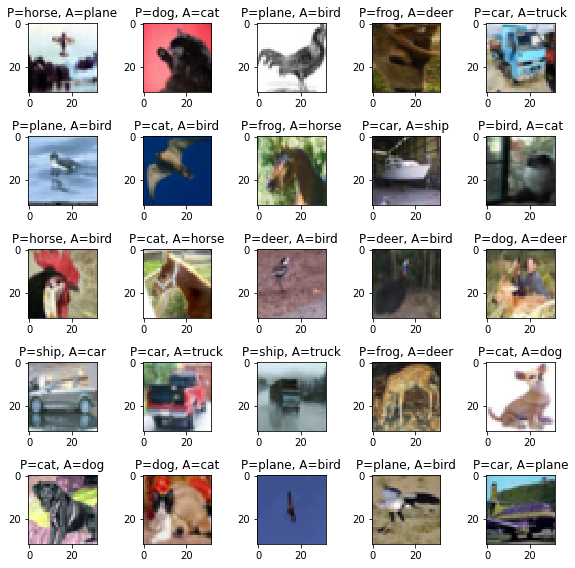

In [0]:
evaluate.view_misclassified_images(model, device, testloader, classes)

Text(0.5, 1.0, 'Test Accuracy')

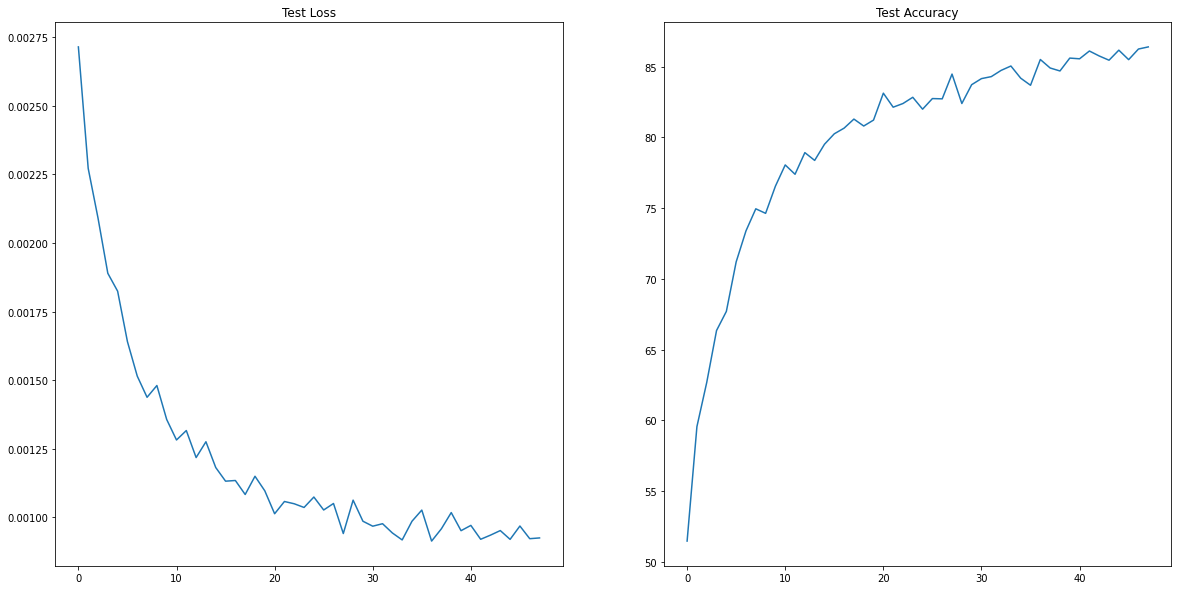

In [0]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2, figsize=(20,10))

axs[0].plot(test_loss)
axs[0].set_title("Test Loss")

axs[1].plot(test_acc)
axs[1].set_title("Test Accuracy")

In [0]:
# model = model.ResNet18(dropout=0.1).to(device)
# optimizer = optim.SGD(model.parameters(), lr=Best_lr,momentum=0.9 ,weight_decay = 0.0005)
checkpoint = torch.load("/content/gdrive/My Drive/EVA4_S11_CIFAR10_OCP/bestmodel_using_OCP.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
print("Loaded the best model")

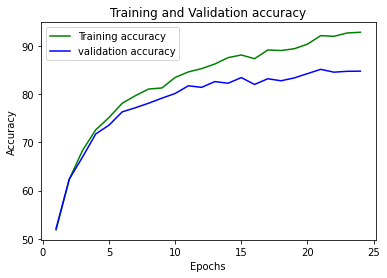

In [16]:
evaluate.plot_train_vs_test_accuracy(epochs, train_acc, test_acc)

Plot cycle LR

In [0]:
iterations = 311
step_size = 100
lr_min = 0.01
lr_max = 1

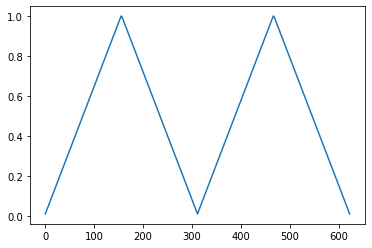

In [0]:
show_images.plot_one_cycle_LR(iterations, step_size, lr_min, lr_max)